In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 28s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_20_tail_cut_2.csv', index_col=[0])
print(shap_summary_df.shape)
shap_summary_df.head()

(319, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.315186,91.825223,93.215765,92.806441,92.257267,92.683976
공시지가(만원),79.483978,79.930549,76.587614,78.422867,77.533691,78.391740
year_linear,64.042216,64.104707,63.103722,63.624817,63.289470,63.632987
건축년도,46.551421,48.588114,48.952253,48.234778,46.036206,47.672554
전용면적,40.885406,38.878602,39.441897,39.659911,37.260991,39.225362


In [13]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [14]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.315186,91.825223,93.215765,92.806441,92.257267,92.683976
공시지가(만원),79.483978,79.930549,76.587614,78.422867,77.533691,78.391740
year_linear,64.042216,64.104707,63.103722,63.624817,63.289470,63.632987
건축년도,46.551421,48.588114,48.952253,48.234778,46.036206,47.672554
전용면적,40.885406,38.878602,39.441897,39.659911,37.260991,39.225362


In [15]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
제2종전용주거지역,0.003277,0.002876,0.005053,0.011152,0.003701,0.005212
문화시설,0.007041,0.002498,0.005279,0.004657,0.006192,0.005133
국립공원,0.005635,0.009161,0.002942,0.001847,0.005918,0.005101
현상변경허가_대상구역,0.002380,0.009318,0.002646,0.007064,0.002097,0.004701
주_용도_관광휴게시설_fraction,0.000000,0.006176,0.015671,0.000932,0.000101,0.004576
지붕_초가지붕_fraction,0.005531,0.002143,0.010210,0.001544,0.002373,0.004360
방재지구,0.002416,0.001966,0.014547,0.000987,0.001302,0.004244
도시개발구역기타,0.002015,0.001443,0.001095,0.004953,0.011465,0.004194
시장정비구역,0.002689,0.004094,0.005248,0.004064,0.004536,0.004126
국가지정문화재구역,0.009421,0.002251,0.002181,0.002588,0.002652,0.003819


In [16]:
over_point1_df = shap_summary_df[shap_summary_df['shap_summary_mean'] >= 0.1]
print(over_point1_df.shape)

(123, 6)


In [17]:
over_point1_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.315186,91.825223,93.215765,92.806441,92.257267,92.683976
공시지가(만원),79.483978,79.930549,76.587614,78.422867,77.533691,78.391740
year_linear,64.042216,64.104707,63.103722,63.624817,63.289470,63.632987
건축년도,46.551421,48.588114,48.952253,48.234778,46.036206,47.672554
전용면적,40.885406,38.878602,39.441897,39.659911,37.260991,39.225362


In [18]:
over_point1_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
용도지역명2,0.364816,0.264120,0.356742,0.280063,0.265598,0.306268
가로구역별_최고높이_제한지역,0.287773,0.281796,0.324006,0.270725,0.269013,0.286663
주_용도_제1종근린생활시설_fraction,0.377895,0.250920,0.263395,0.253124,0.282778,0.285622
공공주택지구,0.128176,0.314295,0.295590,0.261551,0.411534,0.282229
용도구역기타,0.239543,0.293212,0.204688,0.299806,0.361191,0.279688
완충녹지,0.291537,0.413656,0.242221,0.194745,0.209588,0.270349
중로2류(폭_15M~20M),0.310577,0.247789,0.215407,0.278052,0.216432,0.253651
상수원보호기타,0.263771,0.223843,0.199120,0.294755,0.235601,0.243418
대로3류(폭_25M~30M),0.168805,0.255991,0.246707,0.291366,0.154698,0.223513
수평표면구역,0.329374,0.175508,0.160151,0.170880,0.269133,0.221009


In [20]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [21]:
training_data_df = training_data_df[over_point1_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 128)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,옥내자주식대수,아파트지구,호수대비부속건축물면적,호수대비연면적,xnorm,총호수,층,호수대비주차수,y_2nd,용도지역명1,층norm,지구단위계획구역,지붕_평지붕_fraction,가축사육제한구역,부속건축물면적,month_sin,도로접면,건물나이,지형높이,층min,공원,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,부속건축물수,지형형상,상대정화구역,y_sin,x_sin,y_cos,x_cos,제2종일반주거지역,옥내기계식대수,중점경관관리구역,제1종지구단위계획구역,제3종일반주거지역,총외필지수,정비구역,장애물제한표면구역,학교,재정비촉진지구,진입표면구역,학교환경위생_정화구역,교육환경보호구역,도시지역,month_cos,도로,주_용도_공동주택_fraction,일반상업지역,epi점수,일반미관지구,대공방어협조구역,주_용도_제2종근린생활시설_fraction,대공방어협조구역(위탁고도77-257m),벽돌구조_fraction,역사문화미관지구,제1종일반주거지역,지붕_철콘지붕_fraction,중심지미관지구,준공업지역,비행안전제2구역(전술),방화지구,용도지역명2,가로구역별_최고높이_제한지역,주_용도_제1종근린생활시설_fraction,공공주택지구,용도구역기타,완충녹지,중로2류(폭_15M~20M),상수원보호기타,대로3류(폭_25M~30M),수평표면구역,도시철도,자연녹지지역,절대보호구역,비행안전제3구역(전술),과밀억제권역,지붕_기와지붕_fraction,주_용도_노유자시설_fraction,지붕_경사지붕_fraction,경관녹지,녹지,준보전산지,건축선,자연경관지구,소로2류(폭_8M~10M),공공공지,최고고도지구,원추표면구역,도시관리계획_입안중,대공방어협조구역(위탁고도54-236m),주_용도_판매시설_fraction,제한보호구역(후방지역500m),지목명,하천,공장설립승인지역,국민임대주택단지예정지구,주_용도_교육연구시설_fraction,주_용도_업무시설_fraction,근린공원,건축허가_착공제한지역,도시기타용도지역지구미분류,공장설립제한지역,경관지구,고도지구,준주거지역,공공청사,재개발구역,어린이공원,주_용도_자동차관련시설_fraction,용도구역미분류,일반철골구조_fraction,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0.0,0,0.0,98.537963,5579.095707,54.0,2,0.0,4.094180e+07,0,0.222222,0,1.0,0,0.0,-0.866025,0,0,0,9.0,0,0.0,0,0.0,0,0,-0.920469,-0.364267,0.390815,0.931294,0,0.0,0,0,0,1.0,0,0,0,0,0,0,0,0,-0.500000,0,1.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0.0,0,0.0,98.537963,5579.095707,54.0,2,0.0,4.094180e+07,0,0.222222,0,1.0,0,0.0,-0.500000,0,0,0,9.0,0,0.0,0,0.0,0,0,-0.920469,-0.364267,0.390815,0.931294,0,0.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0.866025,0,1.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0.0,0,0.0,98.537963,5579.095707,54.0,4,0.0,4.094180e+07,0,0.444444,0,1.0,0,0.0,0.000000,0,0,0,9.0,0,0.0,0,0.0,0,0,-0.920469,-0.364267,0.390815,0.931294,0,0.0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.000000,0,1.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0.0,0,0.0,98.537963,5579.095707,54.0,9,0.0,4.094180e+07,0,1.000000,0,1.0,0,0.0,0.866025,0,0,0,9.0,0,0.0,0,0.0,0,0,-0.920469,-0.364267,0.390815,0.931294,0,0.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0.500000,0,1.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0.0,0,0.0,98.537963,5579.095707,54.0,1,0.0,4.094180e+07,0,0.111111,0,1.0,0,0.0,-0.866025,0,0,0,9.0,0,0.0,0,0.0,0,0,-0.920469,-0.364267,0.390815,0.931294,0,0.0,0,0,0,1.0,0,0,0,0,0,0,0,0,-0.500000,0,1.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [22]:
from sklearn.model_selection import KFold, GroupKFold

In [23]:
import lightgbm as lgb

In [24]:
from sklearn.metrics import r2_score

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

77

In [27]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 123)
y dist plot


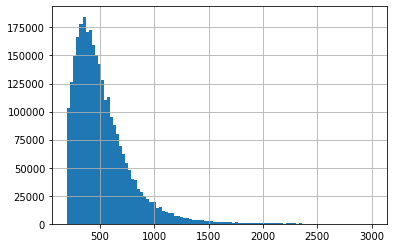

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7153
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 123


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6288
[100]	valid_0's huber: 64.8184
[150]	valid_0's huber: 58.678
[200]	valid_0's huber: 55.0178
[250]	valid_0's huber: 52.4319
[300]	valid_0's huber: 50.6018
[350]	valid_0's huber: 49.1859
[400]	valid_0's huber: 48.1563
[450]	valid_0's huber: 47.1976
[500]	valid_0's huber: 46.3767
[550]	valid_0's huber: 45.6146
[600]	valid_0's huber: 44.9601
[650]	valid_0's huber: 44.385
[700]	valid_0's huber: 43.9361
[750]	valid_0's huber: 43.4349
[800]	valid_0's huber: 43.0794
[850]	valid_0's huber: 42.704
[900]	valid_0's huber: 42.2946
[950]	valid_0's huber: 41.9614
[1000]	valid_0's huber: 41.6599
[1050]	valid_0's huber: 41.4074
[1100]	valid_0's huber: 41.129
[1150]	valid_0's huber: 40.9218
[1200]	valid_0's huber: 40.677
[1250]	valid_0's huber: 40.4454
[1300]	valid_0's huber: 40.2415
[1350]	valid_0's huber: 40.0196
[1400]	valid_0's huber: 39.8549
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


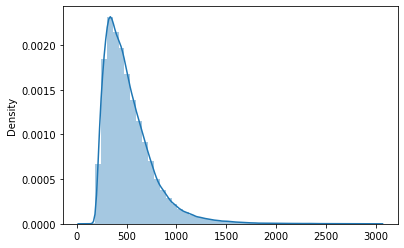

Fold 0 end
Fold 1 start
(2926581, 123)
y dist plot


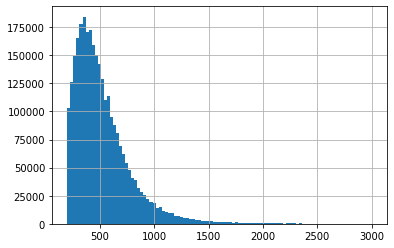

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7147
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 123


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6468
[100]	valid_0's huber: 64.8247
[150]	valid_0's huber: 58.5173
[200]	valid_0's huber: 54.8567
[250]	valid_0's huber: 52.3861
[300]	valid_0's huber: 50.718
[350]	valid_0's huber: 49.2885
[400]	valid_0's huber: 48.0687
[450]	valid_0's huber: 47.1298
[500]	valid_0's huber: 46.3328
[550]	valid_0's huber: 45.5409
[600]	valid_0's huber: 44.9421
[650]	valid_0's huber: 44.3126
[700]	valid_0's huber: 43.8163
[750]	valid_0's huber: 43.4113
[800]	valid_0's huber: 43.0273
[850]	valid_0's huber: 42.6206
[900]	valid_0's huber: 42.243
[950]	valid_0's huber: 41.9369
[1000]	valid_0's huber: 41.6412
[1050]	valid_0's huber: 41.3591
[1100]	valid_0's huber: 41.1174
[1150]	valid_0's huber: 40.8486
[1200]	valid_0's huber: 40.6037
[1250]	valid_0's huber: 40.3889
[1300]	valid_0's huber: 40.1625
[1350]	valid_0's huber: 39.9678
[1400]	valid_0's huber: 39.7763
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


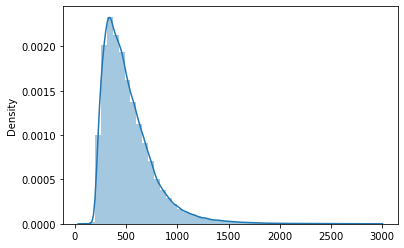

Fold 1 end
Fold 2 start
(2926581, 123)
y dist plot


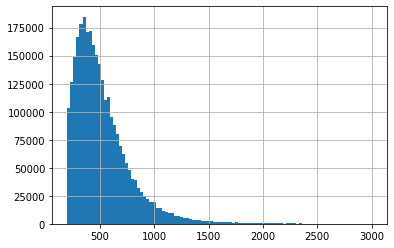

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7156
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 123


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4786
[100]	valid_0's huber: 64.6432
[150]	valid_0's huber: 58.4914
[200]	valid_0's huber: 54.9964
[250]	valid_0's huber: 52.479
[300]	valid_0's huber: 50.7317
[350]	valid_0's huber: 49.3855
[400]	valid_0's huber: 48.2234
[450]	valid_0's huber: 47.349
[500]	valid_0's huber: 46.5228
[550]	valid_0's huber: 45.8587
[600]	valid_0's huber: 45.1626
[650]	valid_0's huber: 44.5794
[700]	valid_0's huber: 44.066
[750]	valid_0's huber: 43.6452
[800]	valid_0's huber: 43.2058
[850]	valid_0's huber: 42.796
[900]	valid_0's huber: 42.3952
[950]	valid_0's huber: 42.0457
[1000]	valid_0's huber: 41.769
[1050]	valid_0's huber: 41.4902
[1100]	valid_0's huber: 41.1878
[1150]	valid_0's huber: 40.9107
[1200]	valid_0's huber: 40.7053
[1250]	valid_0's huber: 40.4426
[1300]	valid_0's huber: 40.2336
[1350]	valid_0's huber: 40.0126
[1400]	valid_0's huber: 39.7964
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


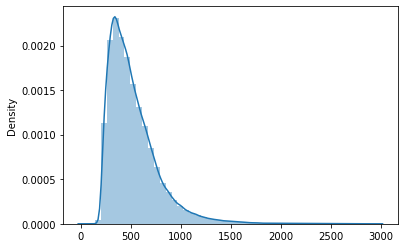

Fold 2 end
Fold 3 start
(2926581, 123)
y dist plot


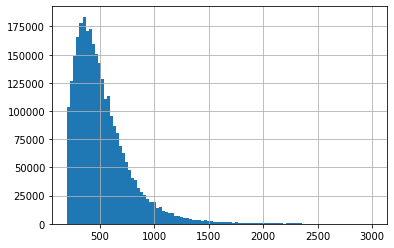

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.389046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7156
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 123


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4318
[100]	valid_0's huber: 64.8586
[150]	valid_0's huber: 58.539
[200]	valid_0's huber: 54.8834
[250]	valid_0's huber: 52.4447
[300]	valid_0's huber: 50.6187
[350]	valid_0's huber: 49.2703
[400]	valid_0's huber: 48.1027
[450]	valid_0's huber: 47.1523
[500]	valid_0's huber: 46.3664
[550]	valid_0's huber: 45.7006
[600]	valid_0's huber: 45.0989
[650]	valid_0's huber: 44.5299
[700]	valid_0's huber: 44.0658
[750]	valid_0's huber: 43.6118
[800]	valid_0's huber: 43.1773
[850]	valid_0's huber: 42.7613
[900]	valid_0's huber: 42.3978
[950]	valid_0's huber: 42.086
[1000]	valid_0's huber: 41.7825
[1050]	valid_0's huber: 41.5111
[1100]	valid_0's huber: 41.2397
[1150]	valid_0's huber: 40.9838
[1200]	valid_0's huber: 40.7618
[1250]	valid_0's huber: 40.5386
[1300]	valid_0's huber: 40.3402
[1350]	valid_0's huber: 40.0981
[1400]	valid_0's huber: 39.876
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


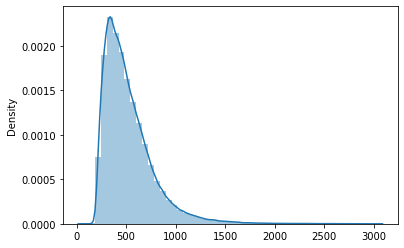

Fold 3 end
Fold 4 start
(2926581, 123)
y dist plot


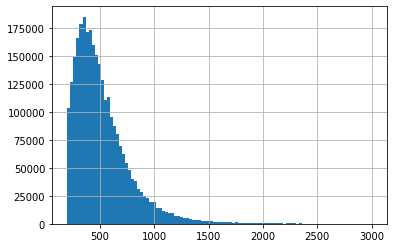

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7148
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 123


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.2975
[100]	valid_0's huber: 64.7087
[150]	valid_0's huber: 58.4868
[200]	valid_0's huber: 54.8776
[250]	valid_0's huber: 52.4704
[300]	valid_0's huber: 50.6301
[350]	valid_0's huber: 49.2113
[400]	valid_0's huber: 48.1104
[450]	valid_0's huber: 47.2275
[500]	valid_0's huber: 46.4081
[550]	valid_0's huber: 45.7423
[600]	valid_0's huber: 45.1099
[650]	valid_0's huber: 44.5909
[700]	valid_0's huber: 44.0481
[750]	valid_0's huber: 43.63
[800]	valid_0's huber: 43.1574
[850]	valid_0's huber: 42.7304
[900]	valid_0's huber: 42.381
[950]	valid_0's huber: 42.0601
[1000]	valid_0's huber: 41.752
[1050]	valid_0's huber: 41.4802
[1100]	valid_0's huber: 41.1892
[1150]	valid_0's huber: 40.9066
[1200]	valid_0's huber: 40.6392
[1250]	valid_0's huber: 40.4308
[1300]	valid_0's huber: 40.2318
[1350]	valid_0's huber: 40.0429
[1400]	valid_0's huber: 39.8429
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


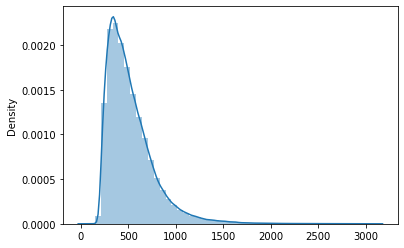

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [29]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_point1_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

66.09745774478847

In [32]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [33]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [34]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [35]:
shap_summary_df.index = x_train.columns

In [36]:
shap_summary_df.to_csv(basedir + 'shap_point1.csv')

In [37]:
#